# Yolov8 Model Evaluation

This notebook helps evaluate a trained yolo model. Graphs are shown, along with sample batches of data and a few general inferences

## 1. Imports and variable setup

In [1]:
# Import all libraries
import os
import ultralytics
from ultralytics import YOLO
from IPython.display import display, Image, Video
from pathlib import Path
import sys
import glob
import random
import cv2
import numpy as np
import supervision as sv
# from dbdkillerai.models.predict_model import process_frame
# Setup HOME environment variable
HOME = os.getcwd()
print(HOME)
from ipywidgets import Video as ipyVideo

/Users/mreagles524/Documents/gitrepos/projects/DBD-Killer-AI/notebooks


In [2]:
# Check image displays are good
# display.clear_output()
sys.path.append(str(Path.cwd().parent))
# Check ultralytics library is good
ultralytics.checks()

Ultralytics 8.3.53 🚀 Python-3.11.8 torch-2.5.1 CPU (Apple M1 Pro)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 264.9/460.4 GB disk)


In [3]:
# Environment variables
PROJECT_DIR = Path.cwd().parent
DATASET_VERSION = 9

In [4]:
data_directory = str(PROJECT_DIR) + f"/data/external/deadbydaylightkillerai/killer_ai_object_detection/{DATASET_VERSION}"
yaml_directory = data_directory + "/data.yaml"

## 2. Import Model

Find the best model amongst all runs of training runs.

**Note**:
- mAP under "train" folders correspond to mAP agaisnt validation data
- mAP under "val" folders correspond to map against test data
    - Per this response from developers: https://github.com/ultralytics/ultralytics/issues/3737#issuecomment-1813520866

To move along in the project, we will only focus on models that ran against training/validation data.

In [5]:
from dbdkillerai.utils.utils import find_best_model

# Grab the best model from the runs directory, only validation(train) runs
# target_data_value is the desired dataset to filter runs from.
best_model_info = find_best_model(runs_directory="runs/detect/",
                                   folder_type="train", # train = "val" mAP
                                   target_data_value=f"deadbydaylightkillerai/killer_ai_object_detection/{DATASET_VERSION}")
if best_model_info is not None:
    run_folder = best_model_info["model_folder"]
    model = YOLO(model=best_model_info["weights_path"])

Model Folder: runs/detect/train7
Weights Path: runs/detect/train7/weights/best.pt
mAP: 0.09891


### Determine present classes within this dataset.

In [6]:
from dbdkillerai.utils.utils import load_labels_from_yaml

dataset_labels = load_labels_from_yaml(yaml_directory)
print(dataset_labels)

['generator', 'hook', 'survivor', 'survivor_downed']


## 3. Model Evaluation

### Confusion Matrix

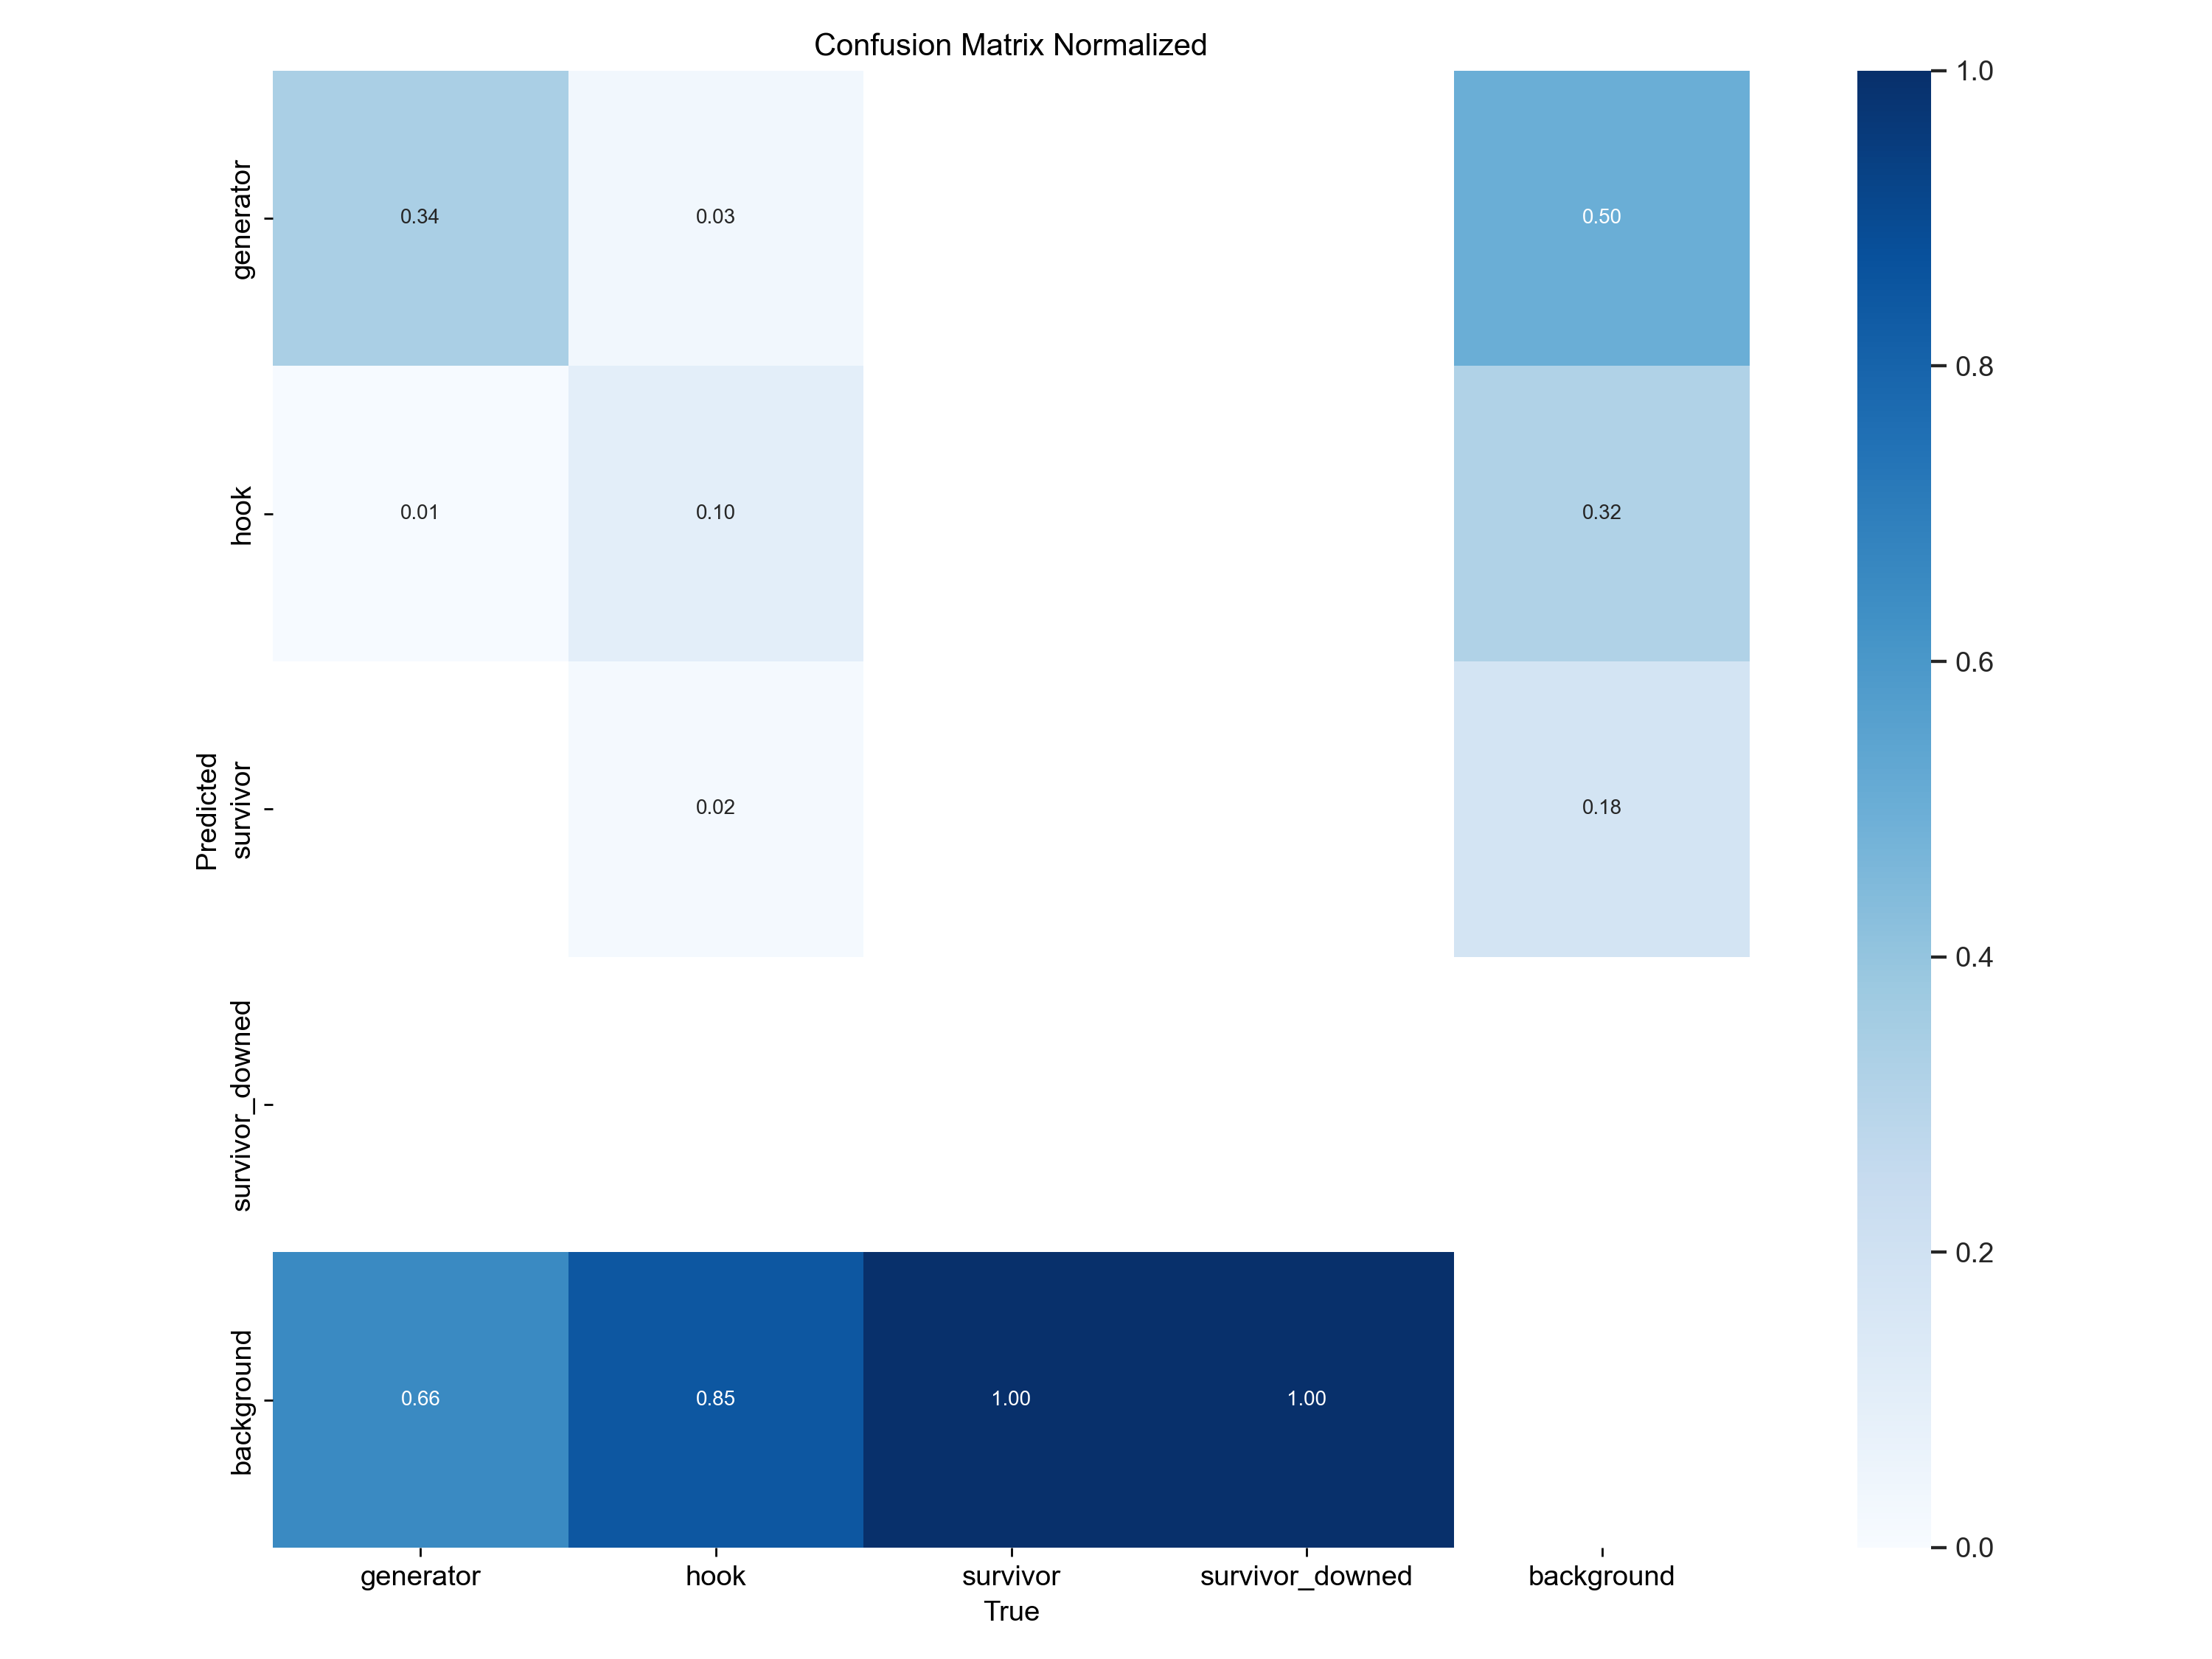

In [7]:
Image(filename=f'{PROJECT_DIR}/notebooks/{run_folder}/confusion_matrix_normalized.png', width=1200)

### Loss Graphs

#### F1 Curve

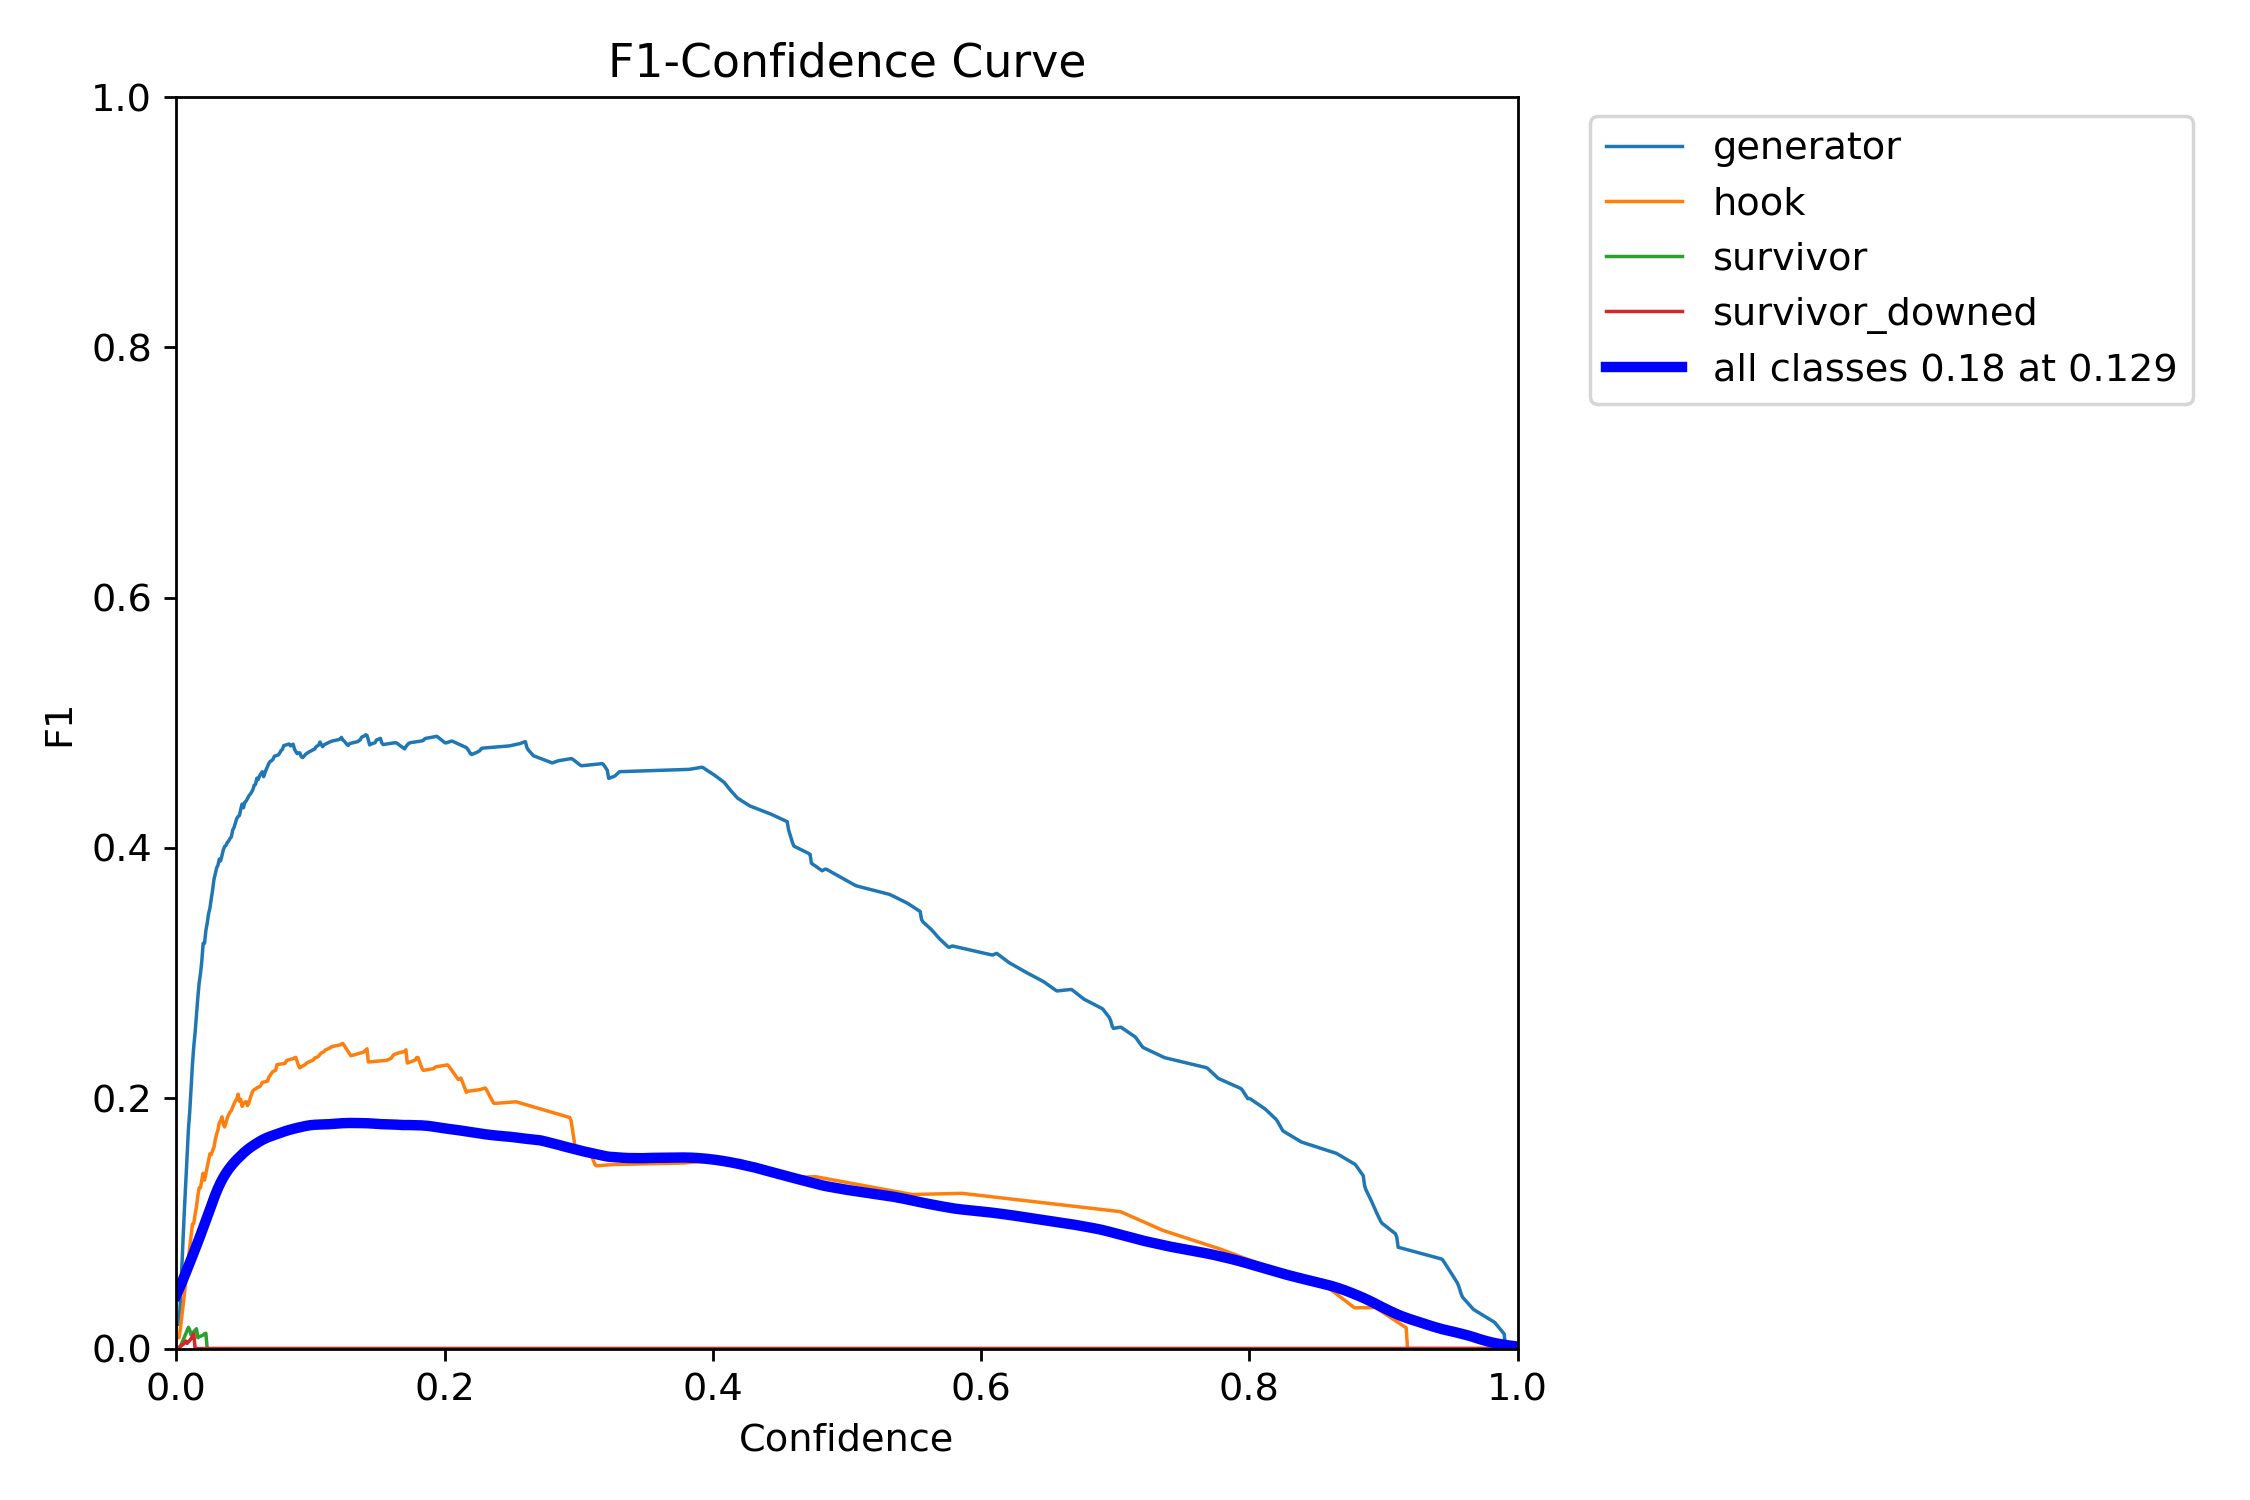

In [8]:
Image(filename=f'{PROJECT_DIR}/notebooks/{run_folder}/F1_curve.png', width=1200)

#### Precision Curve

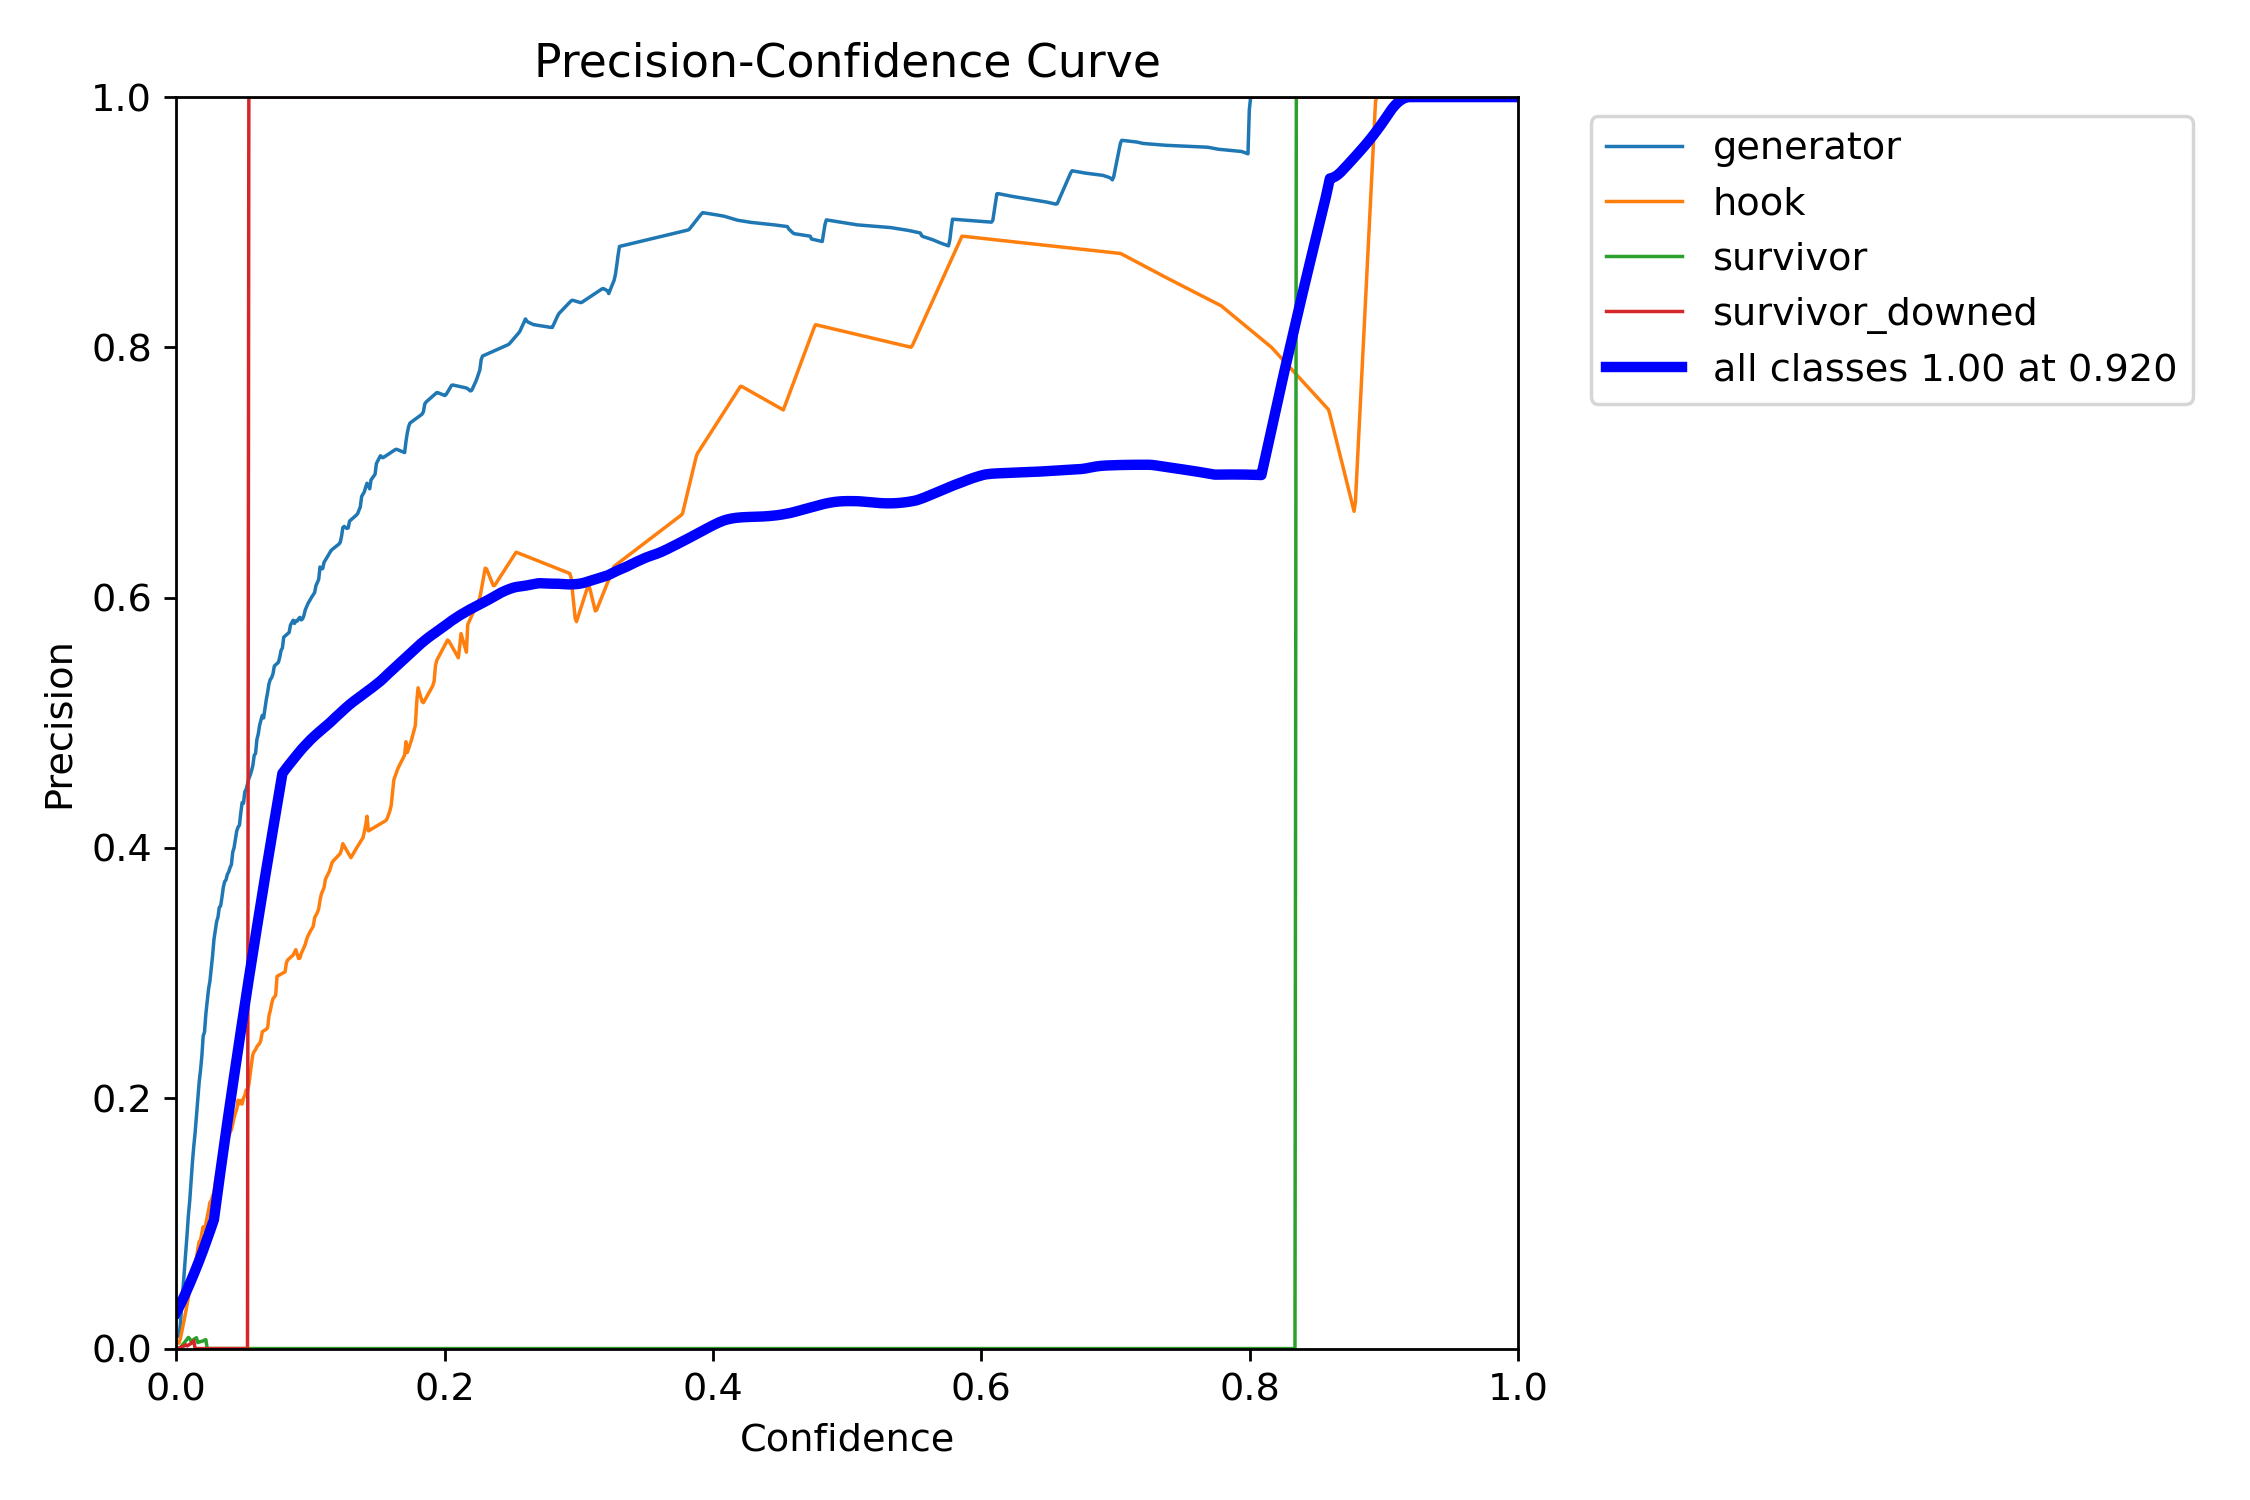

In [10]:
Image(filename=f'{PROJECT_DIR}/notebooks/{run_folder}/P_curve.png', width=1200)

#### Precision/Recall Curve

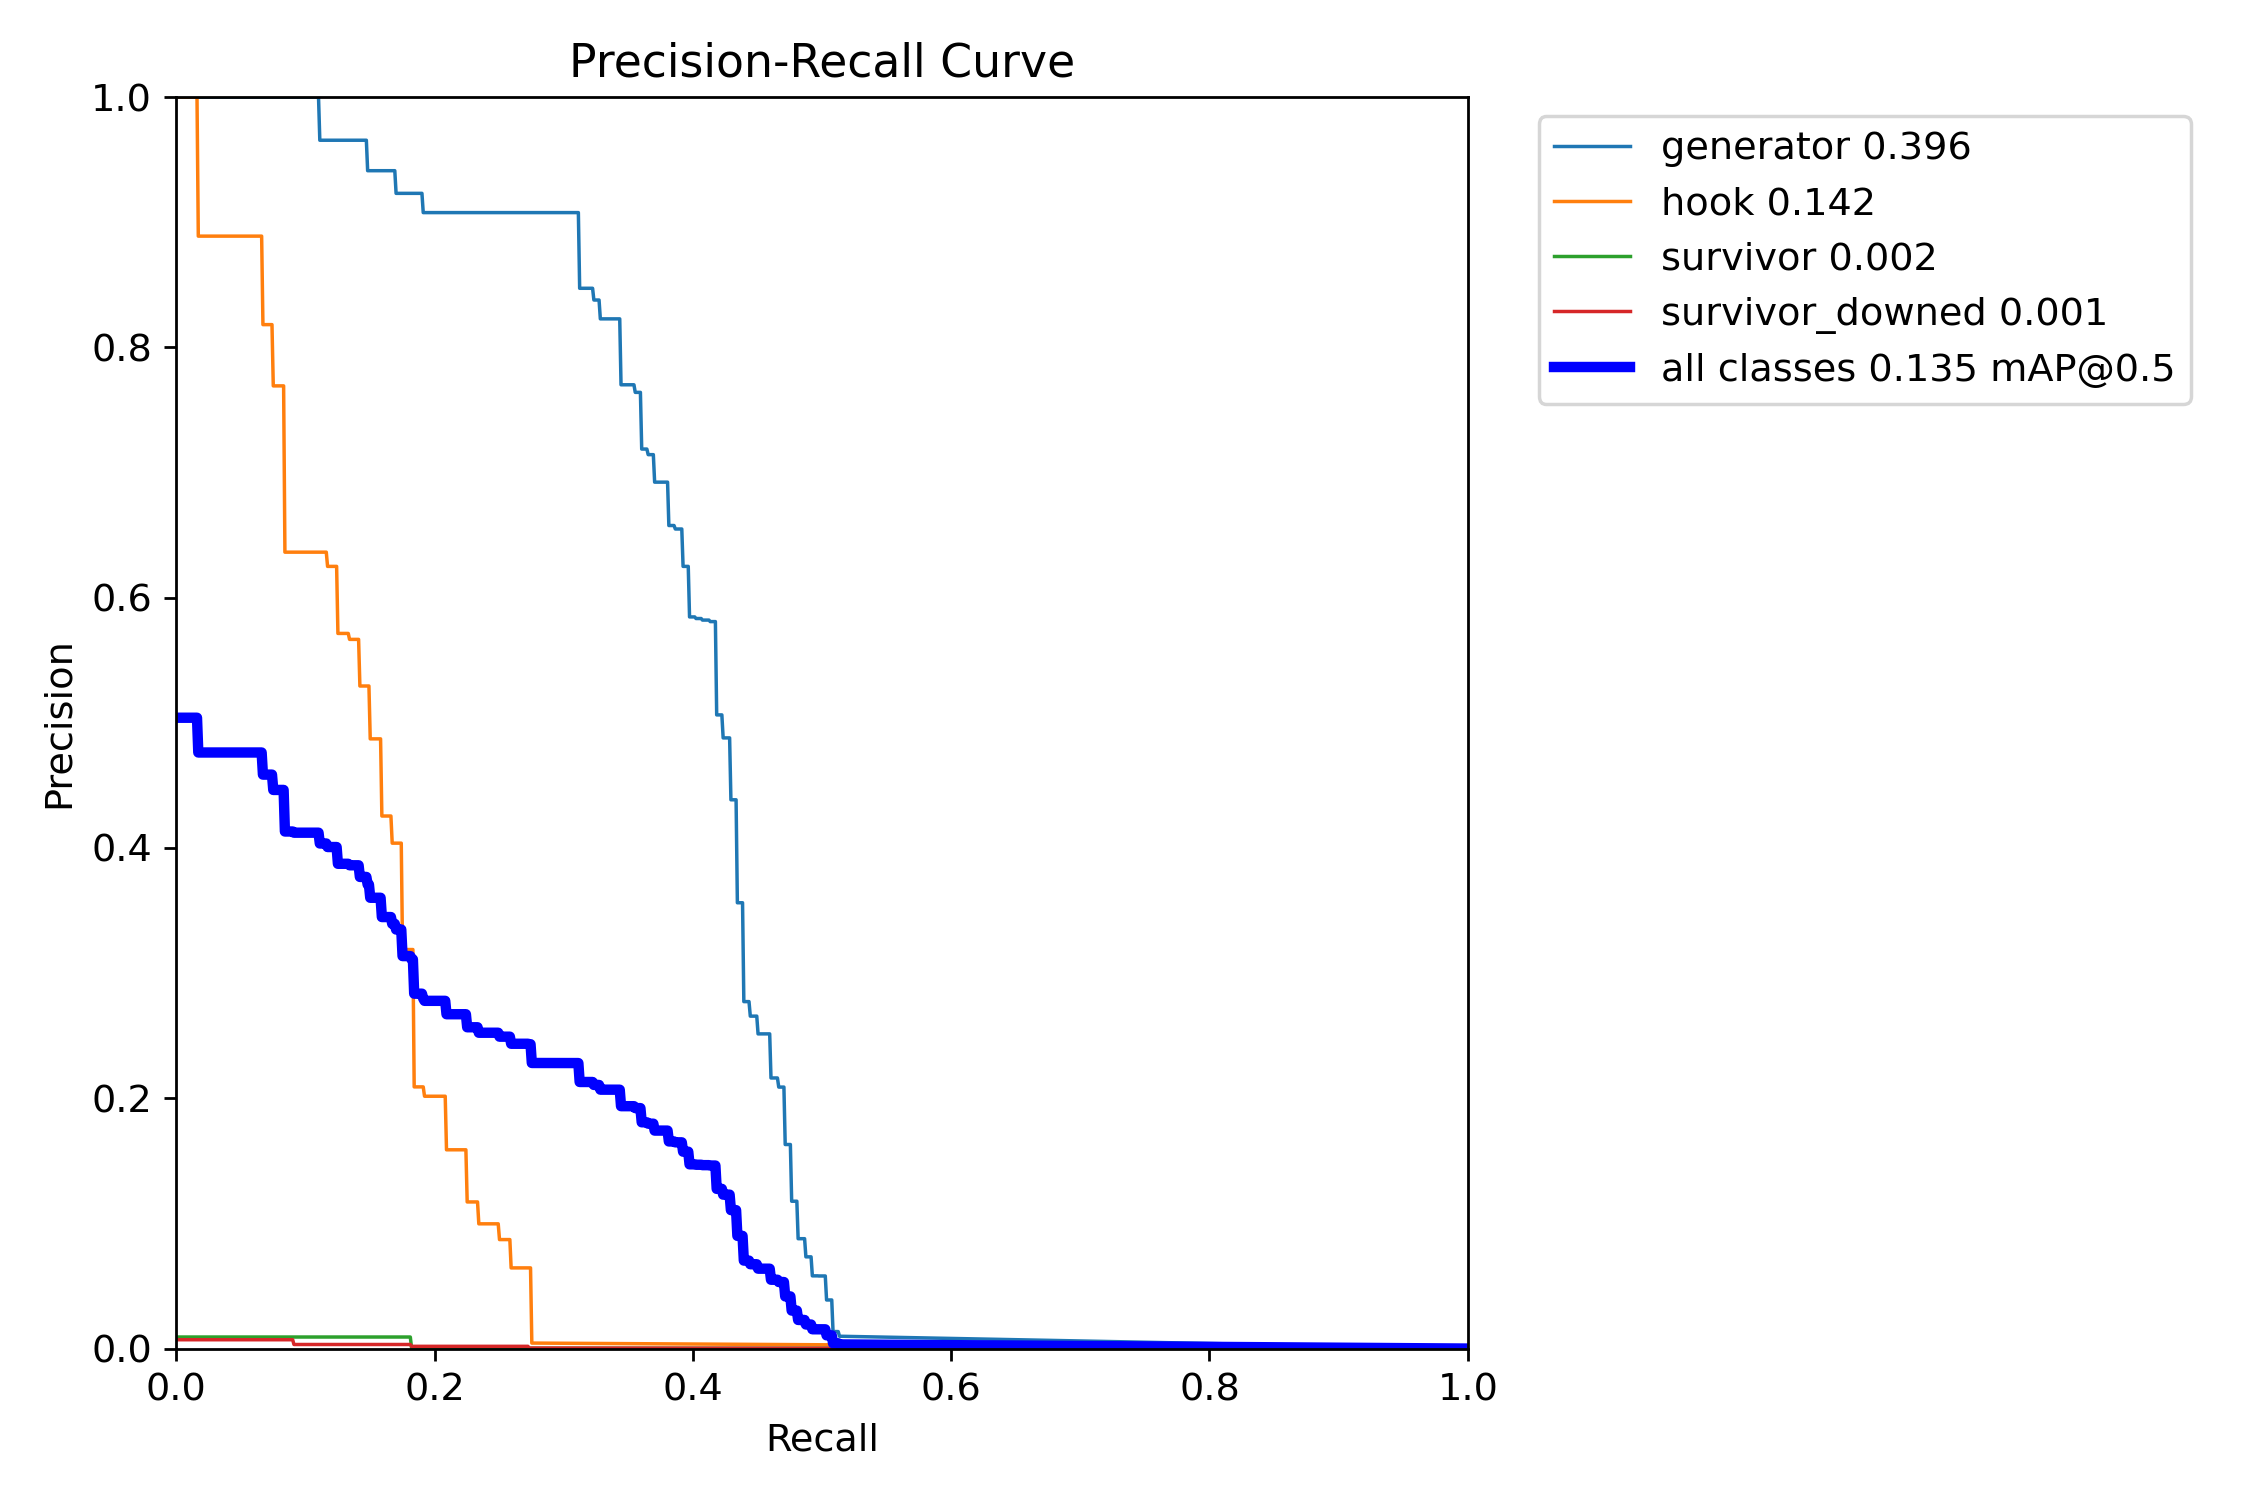

In [11]:
Image(filename=f'{PROJECT_DIR}/notebooks/{run_folder}/PR_curve.png', width=1200)

#### Loss Plots

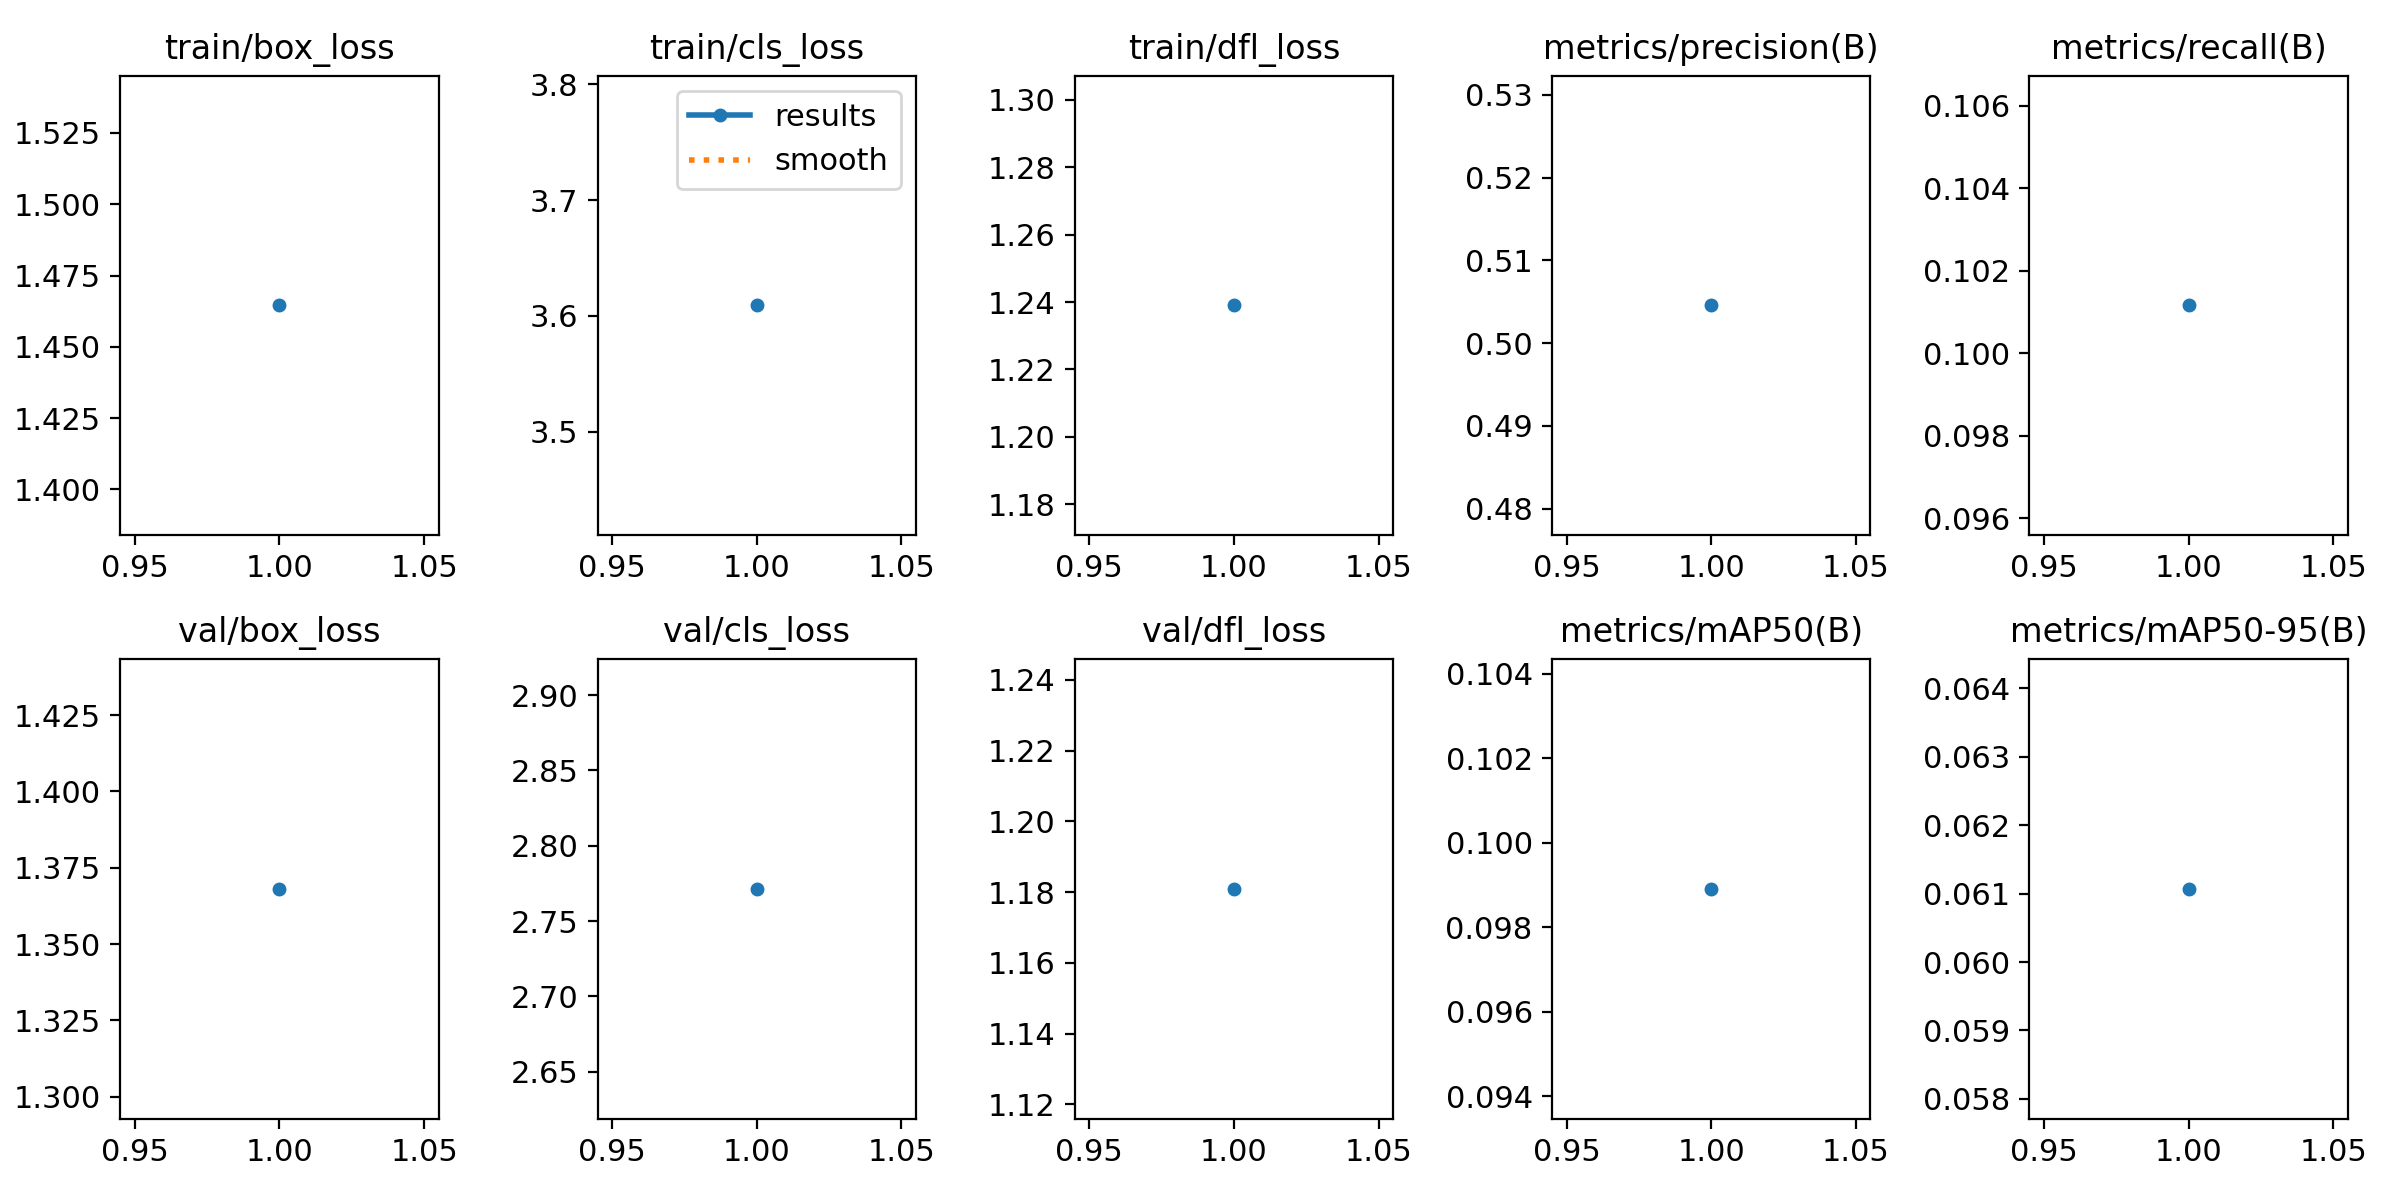

In [12]:
Image(filename=f'{PROJECT_DIR}/notebooks/{run_folder}/results.png', width=1200)

### Training Batch Eval

Showing Batch instances of Training data

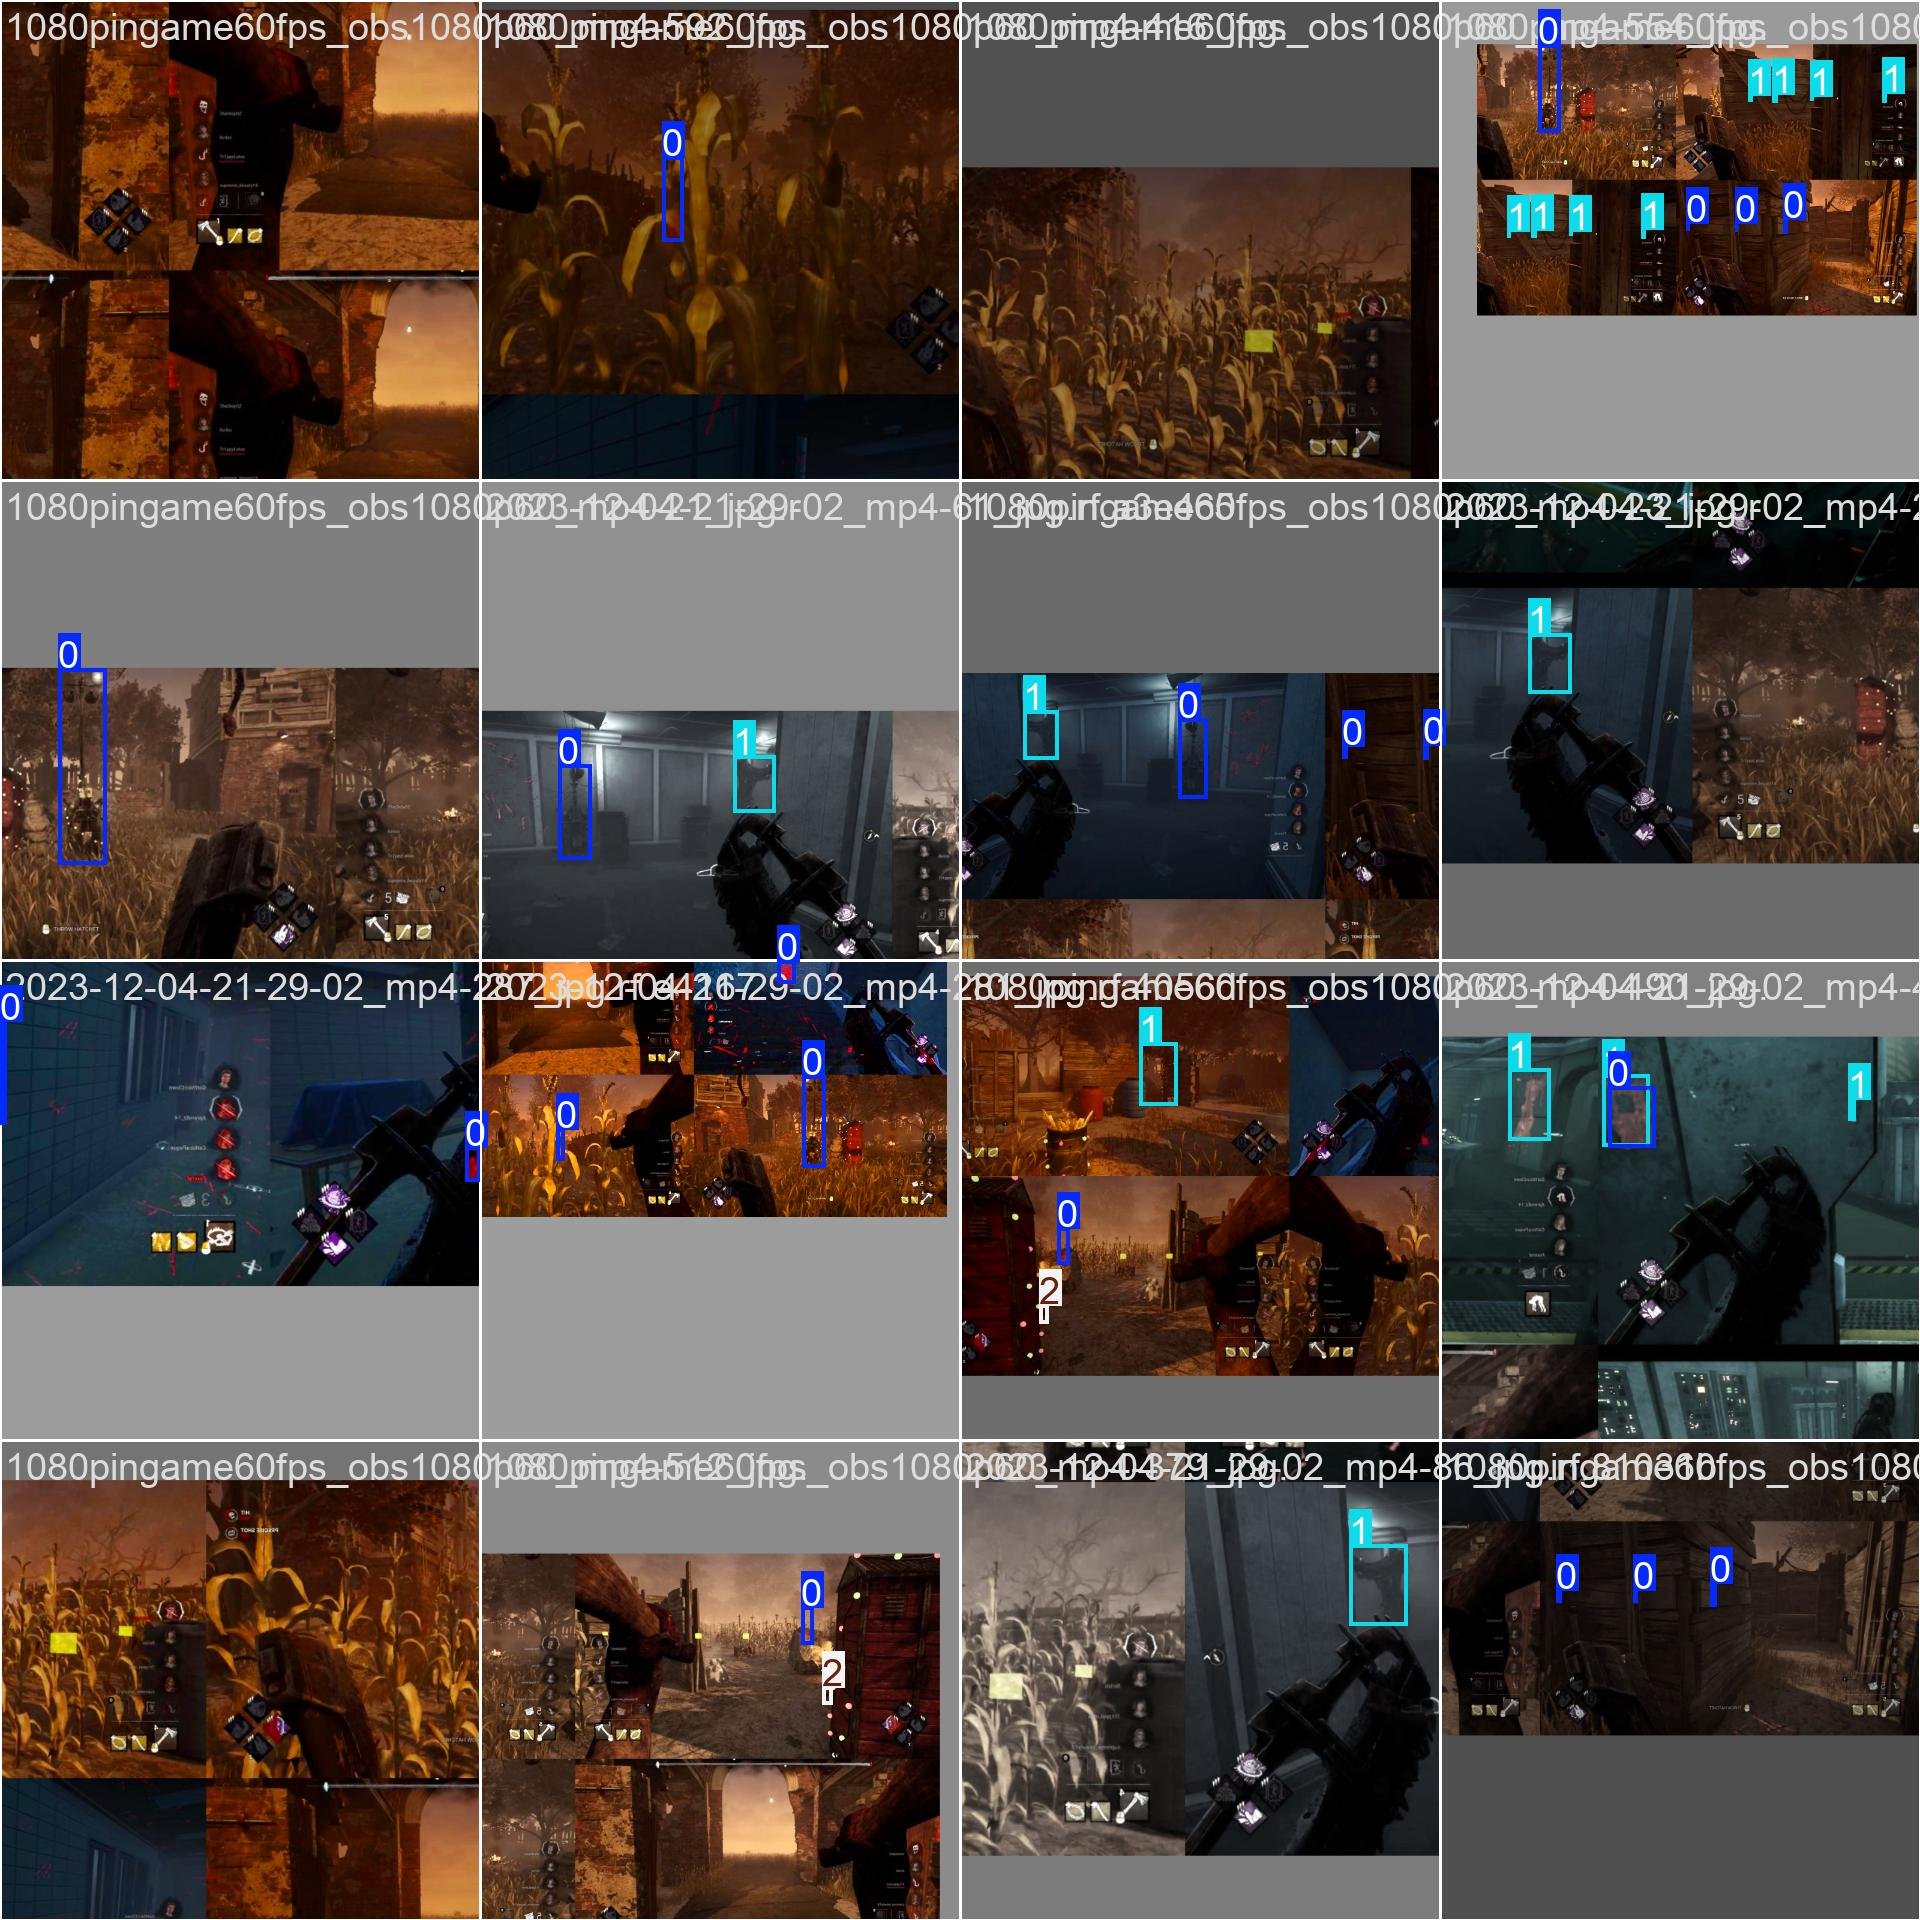

In [13]:
Image(filename=f'{PROJECT_DIR}/notebooks/{run_folder}/train_batch0.jpg', width=1200)

### Validation Batch Eval

Showing Batch instances of Validation data

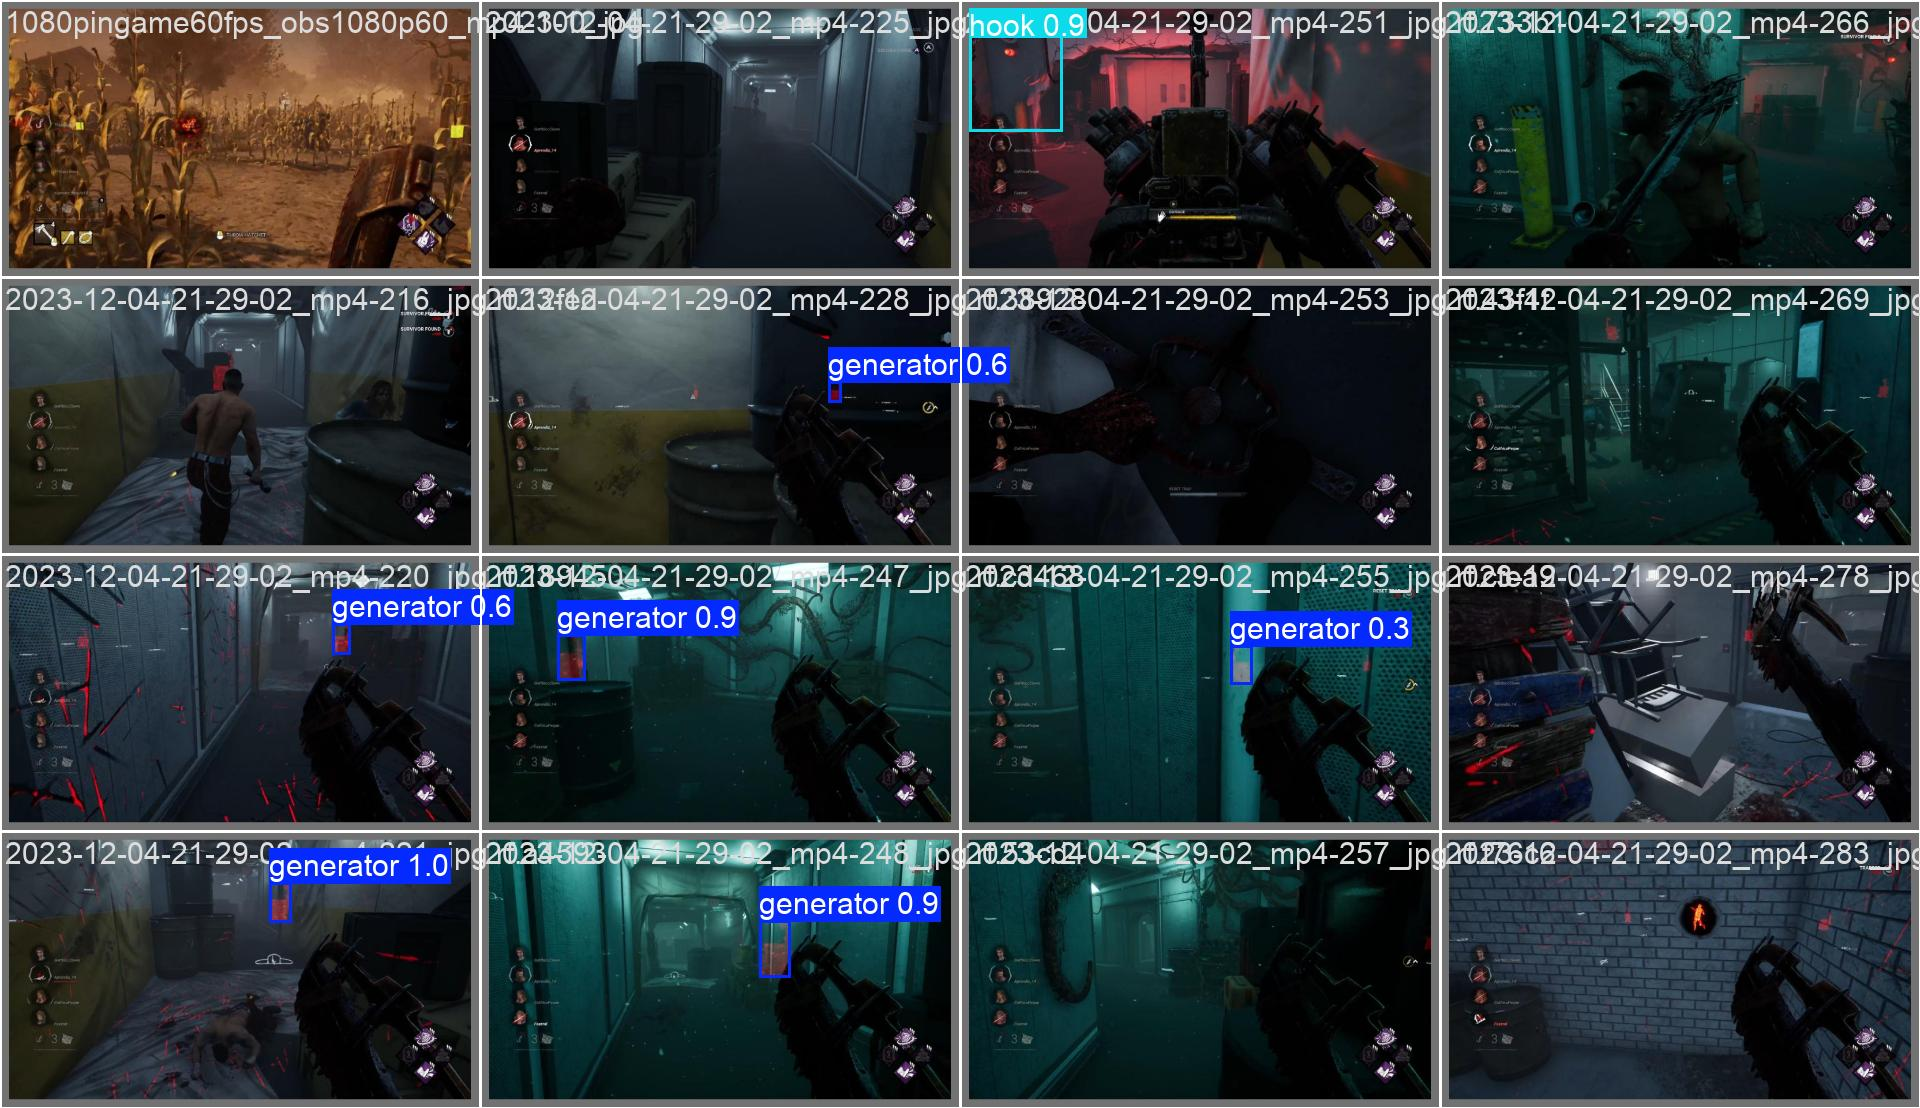

In [14]:
Image(filename=f'{PROJECT_DIR}/notebooks/{run_folder}/val_batch0_pred.jpg', width=1200)

## 4. Model Inference (Image)

Images will use the test dataset

In [15]:
pred_results = model.predict(source=data_directory + "/test/images", save=True)

image 1/119 /Users/mreagles524/Documents/gitrepos/projects/DBD-Killer-AI/data/external/deadbydaylightkillerai/killer_ai_object_detection/9/test/images/1080pingame60fps_obs1080p60_mp4-0_jpg.rf.b46806b79ed0a4d256da2ded496169ee.jpg: 480x800 (no detections), 65.7ms
image 2/119 /Users/mreagles524/Documents/gitrepos/projects/DBD-Killer-AI/data/external/deadbydaylightkillerai/killer_ai_object_detection/9/test/images/1080pingame60fps_obs1080p60_mp4-109_jpg.rf.938ca613ca9ec858f39ae6538802486e.jpg: 480x800 (no detections), 52.6ms
image 3/119 /Users/mreagles524/Documents/gitrepos/projects/DBD-Killer-AI/data/external/deadbydaylightkillerai/killer_ai_object_detection/9/test/images/1080pingame60fps_obs1080p60_mp4-110_jpg.rf.63b00235dd05a2c657c8586ed28b994f.jpg: 480x800 (no detections), 48.7ms
image 4/119 /Users/mreagles524/Documents/gitrepos/projects/DBD-Killer-AI/data/external/deadbydaylightkillerai/killer_ai_object_detection/9/test/images/1080pingame60fps_obs1080p60_mp4-113_jpg.rf.380ee855179b4367

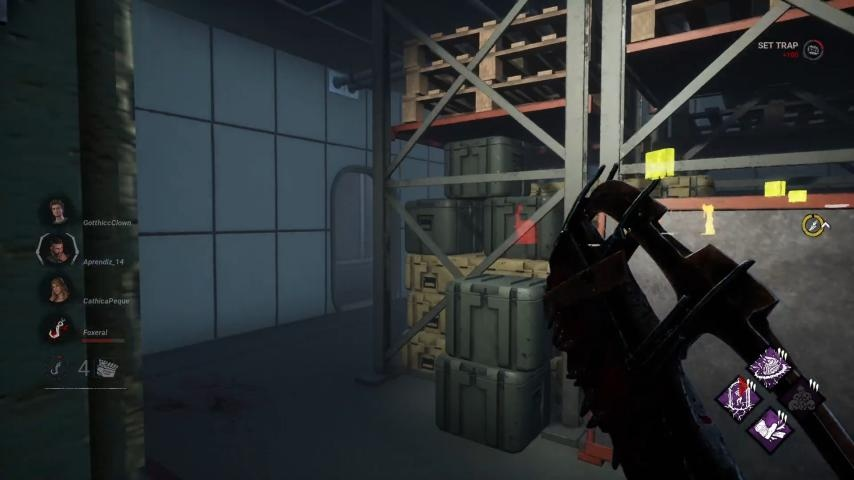

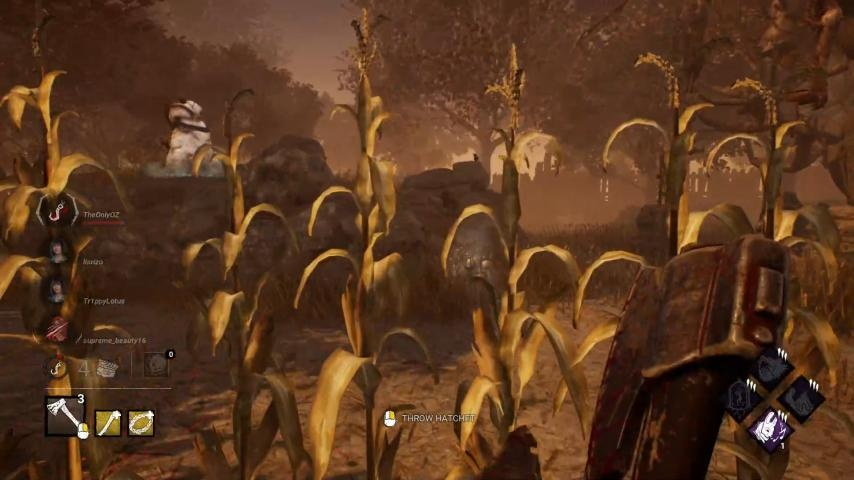

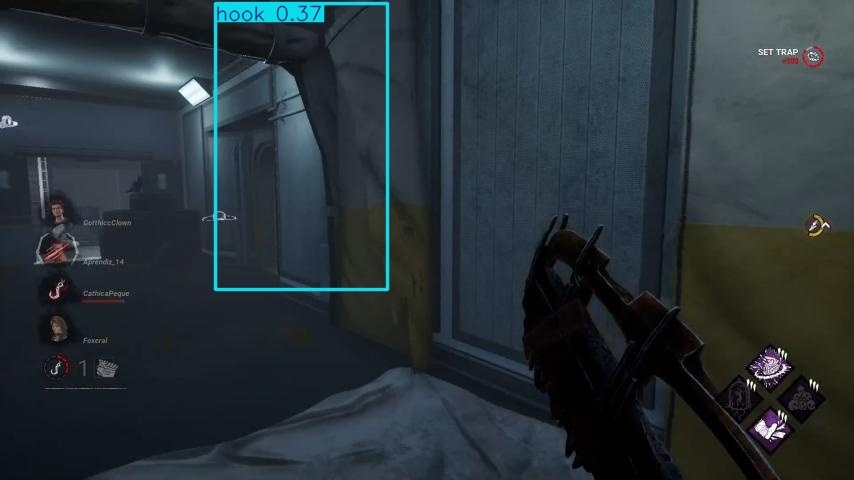

In [16]:
# Number of images to display
num_images_to_display = 3

# Get a list of all image paths in the directory
image_paths = glob.glob(f'{pred_results[0].save_dir}/*.jpg')

# Randomly select a subset of images
selected_image_paths = random.sample(image_paths, num_images_to_display)

for image_path in selected_image_paths:
      display(Image(filename=image_path, width=600, height=400))
      print("\n")

## 5. Model Inference (Video)

In [26]:
# Open the video file
VIDEO_PATH = f"{PROJECT_DIR}/data/raw/huntress_chase.mp4"
cap = cv2.VideoCapture(VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(VIDEO_PATH)

def process_frame2(frame: np.ndarray, _) -> np.ndarray:
    results = model(frame, imgsz=1280)[0]
    
    detections = sv.Detections.from_ultralytics(results)
    #TODO. fix this for an output video
    # box_annotator = sv.BoundingBoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
    box_annotator = sv.BoxAnnotator()

    labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, _, confidence, class_id, _, _ in detections]
    frame = box_annotator.annotate(scene=frame, detections=detections) #, labels=labels)

    return frame


model_name = best_model_info['model_folder'].replace('/', '_')
sv.process_video(source_path=VIDEO_PATH,
                 target_path=f"{PROJECT_DIR}/data/processed/huntress_chase_{model_name}.mp4",
                 callback=process_frame2)



0: 736x1280 3 generators, 103.4ms
Speed: 4.7ms preprocess, 103.4ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 3 generators, 89.3ms
Speed: 4.8ms preprocess, 89.3ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 3 generators, 97.9ms
Speed: 4.1ms preprocess, 97.9ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 3 generators, 100.2ms
Speed: 6.2ms preprocess, 100.2ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 generator, 90.2ms
Speed: 5.3ms preprocess, 90.2ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 4 generators, 90.3ms
Speed: 4.7ms preprocess, 90.3ms inference, 0.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 generators, 117.7ms
Speed: 5.6ms preprocess, 117.7ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 3 generators, 105.7ms
Speed: 4.7ms preprocess, 105.7ms inf

In [27]:
ipyVideo.from_file(f"{PROJECT_DIR}/data/processed/huntress_chase_{model_name}.mp4", width=600)
# Video(f"{PROJECT_DIR}/data/processed/huntress_chase_{model_name}.mp4", embed=True, width=400)

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x06\x0f\xb1\x01...', wi…